In [1]:
from math import ceil
from pathlib import Path
from copy import deepcopy
import sys

sys.path.insert(0, str(Path().absolute().parent))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix
from joblib import Parallel, delayed

In [3]:
from settings import PATH, SETTINGS
from utils import load_data_from_hdf5
from data_convert import process_data_approach_2
from catboost_approach import MyCB, MyCBR

In [4]:
class BigImage():
    def __init__(self, path, base_shape, process_fun=None):
        if process_fun is None:
            process_fun = process_data_approach_2
        self.process_fun = process_fun
        self.base_shape = base_shape
        self.path = path
        self.data = load_data_from_hdf5(path)['data']
        self.parts_1 = []
        self.parts_2 = []
        self.origin_shape = self.data.shape[:2]
        
        for j in range(ceil(self.origin_shape[0] / base_shape[0])):
            if base_shape[0] * (j + 1) <= self.origin_shape[0]:
                zero_dim_ranges = [base_shape[0] * j, base_shape[0] * (j + 1)]
            else:
                zero_dim_ranges = [self.origin_shape[0] - base_shape[0], self.origin_shape[0]]
            for i in range(ceil(self.origin_shape[1] / base_shape[1])):
                if base_shape[1] * (i + 1) <= self.origin_shape[1]:
                    first_dim_ranges = [base_shape[1] * i, base_shape[1] * (i + 1)]
                else:
                    first_dim_ranges = [self.origin_shape[1] - base_shape[1], self.origin_shape[1]]
                subarray = self.data[zero_dim_ranges[0]:zero_dim_ranges[1], first_dim_ranges[0]:first_dim_ranges[1], 0]
                subarray = self.process_fun(subarray)
                self.parts_1.append(subarray)
                
                subarray = self.data[zero_dim_ranges[0]:zero_dim_ranges[1], first_dim_ranges[0]:first_dim_ranges[1], 1]
                subarray = self.process_fun(subarray)
                self.parts_2.append(subarray)


class TM():
    def fit(self, x, y=None):
        return self
    
    def fit_predict(self, x, y=None):
        return self.predict(x)
    
    def score(self, x, y, **kwargs):
        return self.model.score(x, y, **kwargs)
        

class TestModel(TM):
    def __init__(self, model, share_for_predict=0.2, image_shape=SETTINGS['image_shape_for_amp_2'], tqdm=tqdm, limit=100):
        self.model = model
        self.share_for_predict = share_for_predict
        self.image_shape = image_shape
        self.tqdm = tqdm
        self.limit = limit
    
    def predict(self, files):
        result = dict()
        iresult = dict()
        for file in self.tqdm(list(files)):
            image = BigImage(file, self.image_shape)
            r = []
            for i1, i2 in zip(image.parts_1, image.parts_2):
                if isinstance(self.model, MyCB):
                    p1, p2 = self.model.predict_proba(i1)[0][1], self.model.predict_proba(i2)[0][1]
                else:
                    p1, p2 = self.model.predict(i1)[0], self.model.predict(i2)[0]
                r.append(p1 + p2)
            iresult[file.stem] = r
            if len(iresult) > self.limit:
                print('break!')
                break
        self.iresult = iresult
        result = {k: int(np.mean(r) > self.share_for_predict) for k, r in iresult.items()}
        self.result = result
        return pd.Series(result)


class TestModelDirect():
    def __init__(self, model, tqdm=tqdm, limit=100):
        self.model = model
        self.tqdm = tqdm
        self.limit = limit
        
    def predict(self, files):
        r = dict()
        for file in self.tqdm(list(files)):
            array = np.abs(load_data_from_hdf5(file)['data'])
            arrays = [process_data_approach_2(array[:, :, 0]),
                      process_data_approach_2(array[:, :, 1])]
            if isinstance(self.model, MyCB):
                r[file.stem] = (self.model.predict_proba(arrays[0])[0][1], self.model.predict_proba(arrays[1])[0][1])
            else:
                r[file.stem] = (self.model.predict(arrays[0])[0], self.model.predict(arrays[1])[0])
            if len(r) > self.limit:
                print('break!')
                break
        self.iresult = r
        result = {k: int(sum(r) > 1) for k, r in r.items()}
        self.result = result
        return r

In [5]:
%%time
model = MyCB(edge=0)
# model = MyCBR(drop_0=True)
model.read_data()
model.fit(*model.my_test)
# model.fit(*model.my_data)
print(model.score(*model.my_data), model.score(*model.my_data, score_type='f1'))
print(confusion_matrix(model.my_data[1], model.predict(model.my_data[0])))

0.7432982678950764 0.8012617052735337
[[ 5594 14688]
 [ 5474 40644]]
Wall time: 12.7 s


In [6]:
model.predict_mode = 'with_full_preprocessing'

In [7]:
label = pd.read_csv(PATH['data']['origin']['train'] / SETTINGS['labels_file_name']).set_index('id')

In [8]:
%%time
# model_class = TestModel
model_class = TestModelDirect
m = model_class(model, limit=100)
r = m.predict(PATH['data']['origin']['train'].glob('*.hdf5'))

  0%|          | 0/603 [00:00<?, ?it/s]

break!
Wall time: 13.4 s


<AxesSubplot: >

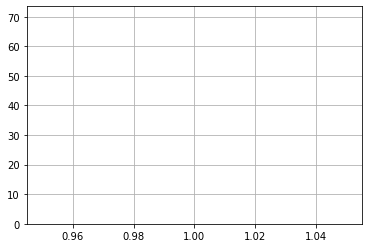

In [9]:
t = pd.concat([label, pd.Series({k: np.mean(x) for k, x in m.iresult.items()})], axis=1).dropna()
# t = pd.concat([label, pd.Series({k: np.mean(sorted(x)[-10:]) for k, x in m.iresult.items()})], axis=1).dropna()
t = pd.concat([label, pd.Series({k: np.max(x) for k, x in m.iresult.items()})], axis=1).dropna()
# t = pd.concat([label, pd.Series({k: np.sum(x) for k, x in m.iresult.items()})], axis=1).dropna()
t.columns = [0, 1]
_, ax = plt.subplots()
bins = np.linspace(t[1].min(), t[1].max(), 50)
t[t[0] == 1][1].hist(ax=ax, bins=bins, alpha=0.3, color='r')
t[t[0] == 0][1].hist(ax=ax, bins=bins, alpha=0.3, color='b')

In [10]:
t = pd.concat([label, pd.Series(m.result)], axis=1).dropna()
t.columns = [1, 0]
print('f1_score', f1_score(t.iloc[:, 0], t.iloc[:, -1]))
print(confusion_matrix(t[1], t[0]))

f1_score 0.8187134502923976
[[ 0 31]
 [ 0 70]]


In [11]:
# a = process_data_approach_2(np.array(load_data_from_hdf5(file)['data']))
# pd.Series(np.reshape(a[:, :, 0], (-1, ))).hist(bins=100)

In [12]:
# load part of train image and plot hist

# files = list(PATH['data']['origin']['train'].glob('*.hdf5'))
# for file in files:
#     if label.loc[file.stem, 'target'] == 0:
#         break

# image = BigImage(file, SETTINGS['image_shape_for_amp_2'])
# array = image.parts_1[0]
# print(array.max(), array.min(), array.mean())
# pd.Series(np.reshape(array, (-1, ))).hist(bins=100)

In [13]:
# load generated image and plot hist

# files = list(PATH['data']['amp_2']['generated'].glob('*.png'))
# db = pd.read_csv(PATH['data']['amp_2']['generated'] / '_snr.csv', index_col=0)
# for file in files:
#     if db.loc[file.stem, 'target'] == 1:
#         break
# array = np.array(Image.open(file))
# print(array.max(), array.min(), array.mean())
# pd.Series(np.reshape(array, (-1, ))).hist(bins=100)

In [14]:
# load train image and plot hist

# array = np.abs(image.data[:, :, 0])
# print(array.max(), array.min(), array.mean())
# pd.Series(np.reshape(array, (-1, ))).hist(bins=100)

In [15]:
array1

NameError: name 'array1' is not defined

In [ ]:
# check data parameters from generated and train folders

def p(a):
    print(a.shape, round(np.mean(a) / a.max(), 3), round(np.var(a) / a.max() / a.max(), 3))

def k(target, n=10):
    files1 = PATH['data']['amp_2']['generated'].glob('*.npy')
    db = pd.read_csv(PATH['data']['amp_2']['generated'] / '_labels.csv', index_col=0)
    files2 = PATH['data']['origin']['train'].glob('*.hdf5')
    label = pd.read_csv(PATH['data']['origin']['train'] / SETTINGS['labels_file_name'], index_col=0)

    for _ in range(n):
        for file1 in files1:
            if db.loc[file1.stem, 'target'] == target:
                break
        array1 = np.load(file1)

        for file2 in files2:
            if label.loc[file2.stem, 'target'] == target:
                break
        array2 = load_data_from_hdf5(file2)['data'][:, :, 0]
        array2 = process_data_approach_2(array2)
        # array2 = model.full_preprocesser(array2)

        p(array1), p(array2)
        print()
    print()

k(0)
k(1)

In [ ]:
%%time
files1 = PATH['data']['amp_2']['generated'].glob('*.npy')
db = pd.read_csv(PATH['data']['amp_2']['generated'] / '_labels.csv', index_col=0)
r = {'m': dict(), 'v': dict()}
for file1 in tqdm(files1):
    array1 = np.load(file1)
    r['m'][file1.stem] = np.mean(array1)
    r['v'][file1.stem] = np.var(array1)
df = {k: pd.concat([pd.Series(r[k]), db['target']], axis=1) for k in r}

for k, dfi in df.items():
    dfi.columns = [0, 1]
    _, ax = plt.subplots()
    bins = np.linspace(dfi[0].min(), dfi[0].max(), 50)
    dfi[dfi[1] == 1][0].hist(ax=ax, bins=bins, alpha=0.3, color='r')
    dfi[dfi[1] == 0][0].hist(ax=ax, bins=bins, alpha=0.3, color='b')

In [ ]:
%%time
files2 = PATH['data']['origin']['train'].glob('*.hdf5')
label = pd.read_csv(PATH['data']['origin']['train'] / SETTINGS['labels_file_name'], index_col=0)
r = {'m': dict(), 'v': dict()}
for file2 in files2:
    array2 = load_data_from_hdf5(file2)['data'][:, :, 0]
    array2 = process_data_approach_2(array2)
    r['m'][file2.stem] = np.mean(array2)
    r['v'][file2.stem] = np.var(array2)
df = {k: pd.concat([pd.Series(r[k]), label['target']], axis=1) for k in r}

for k, dfi in df.items():
    dfi.columns = [0, 1]
    _, ax = plt.subplots()
    bins = np.linspace(dfi[0].min(), dfi[0].max()*0.6, 50)
    dfi[dfi[1] == 1][0].hist(ax=ax, bins=bins, alpha=0.3, color='r')
    dfi[dfi[1] == 0][0].hist(ax=ax, bins=bins, alpha=0.3, color='b')